# TRAVELLING SALESMAN WITH QAOA


## Introduction
 
Travelling Salesman is a very important problem and can be used to optimise a travel route for delivery and logistics companies.

The following resources have been used:
1. https://github.com/Qiskit/qiskit-optimization/blob/main/docs/tutorials/06_examples_max_cut_and_tsp.ipynb
2. https://github.com/QuCO-CSAM/Solving-Combinatorial-Optimisation-Problems-Using-Quantum-Algorithms/blob/main/TravellingSalesmanProblem/Code/TSP_QAOA_Algorithm.ipynb

This notebook makes use of 3 and 4 Indian cities and the distance between them for our data

### QAOA for a 3 cities example

In [1]:
# Importing all the necessary modules for both the cases

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from itertools import permutations
import gzip
from qiskit import*
import time
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import SPSA,COBYLA
from qiskit import IBMQ
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
import qiskit_optimization
import qiskit_optimization.applications.tsp as tsp
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import RealAmplitudes
import matplotlib.axes as axes
import networkx as nx
from qiskit_optimization.applications import Tsp
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

In [2]:
#Importing the data

distance_data = pd.read_csv('C:\\Users\\Abha N K\\Downloads\\Dataset self composed - Copy of distance.csv',index_col = "City- Distance (km)")

In [3]:
distance_data

,Fort,Churchgate,Khetwadi
City- Distance (km),,,
Fort,0.0,2.7,3.7
Churchgate,2.7,0.0,4.5
Khetwadi,3.7,4.5,0.0


In [4]:
np_arr_distance = distance_data.to_numpy()
np_arr_distance


array([[0. , 2.7, 3.7],
       [2.7, 0. , 4.5],
       [3.7, 4.5, 0. ]])

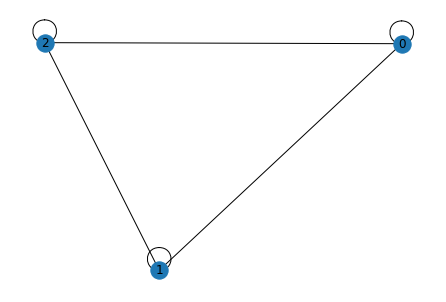

In [5]:
#Visualizing the graph of the movement, with the distances embedded as weights in the edges

graph = nx.Graph()
#p = positions[s]
for n in range(3):
    for b in range(3):
        graph.add_edges_from([[n, b]])
        graph.add_edge(n,b,weight =distance_data.iat[n, b])

#data_cell_1 = distance_data.iat[5, 2]
#data_cell_1
        
nx.draw(graph, with_labels = True)

In [6]:
# retriving the matrix from the graph
tsp_instance = Tsp(graph)
adj_matrix = nx.to_numpy_matrix(tsp_instance.graph)
print("distance\n", adj_matrix)

distance
 [[0.  2.7 3.7]
 [2.7 0.  4.5]
 [3.7 4.5 0. ]]


In [7]:
pos = nx.circular_layout(graph)
pos

{0: array([1.00000000e+00, 1.98682151e-08]),
 1: array([-0.50000007,  0.86602542]),
 2: array([-0.49999993, -0.86602544])}

In [8]:
# Getting the quadratic program from the graph

n = 3
num_qubits = n**2
qp = tsp_instance.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  2.7*x_0_0*x_1_1 + 2.7*x_0_0*x_1_2 + 3.7*x_0_0*x_2_1 + 3.7*x_0_0*x_2_2
  + 2.7*x_0_1*x_1_0 + 2.7*x_0_1*x_1_2 + 3.7*x_0_1*x_2_0 + 3.7*x_0_1*x_2_2
  + 2.7*x_0_2*x_1_0 + 2.7*x_0_2*x_1_1 + 3.7*x_0_2*x_2_0 + 3.7*x_0_2*x_2_1
  + 4.5*x_1_0*x_2_1 + 4.5*x_1_0*x_2_2 + 4.5*x_1_1*x_2_0 + 4.5*x_1_1*x_2_2
  + 4.5*x_1_2*x_2_0 + 4.5*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [9]:
# Process of getting the Ising Hamiltonian from the quadratic program

from qiskit_optimization.converters import QuadraticProgramToQubo
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 414.7500000000003
Ising Hamiltonian:
-69.6 * IIIIIIIIZ
- 69.6 * IIIIIIIZI
- 69.6 * IIIIIIZII
- 70.0 * IIIIIZIII
- 70.00000000000001 * IIIIZIIII
- 70.00000000000003 * IIIZIIIII
- 70.5 * IIZIIIIII
- 70.50000000000001 * IZIIIIIII
- 70.50000000000003 * ZIIIIIIII
+ 33.2 * IIIIIIIZZ
+ 33.2 * IIIIIIZIZ
+ 33.2 * IIIIIIZZI
+ 33.2 * IIIIIZIIZ
+ 0.675 * IIIIIZIZI
+ 0.675 * IIIIIZZII
+ 0.675 * IIIIZIIIZ
+ 33.2 * IIIIZIIZI
+ 0.675 * IIIIZIZII
+ 33.2 * IIIIZZIII
+ 0.675 * IIIZIIIIZ
+ 0.675 * IIIZIIIZI
+ 33.2 * IIIZIIZII
+ 33.2 * IIIZIZIII
+ 33.2 * IIIZZIIII
+ 33.2 * IIZIIIIIZ
+ 0.925 * IIZIIIIZI
+ 0.925 * IIZIIIZII
+ 33.2 * IIZIIZIII
+ 1.125 * IIZIZIIII
+ 1.125 * IIZZIIIII
+ 0.925 * IZIIIIIIZ
+ 33.2 * IZIIIIIZI
+ 0.925 * IZIIIIZII
+ 1.125 * IZIIIZIII
+ 33.2 * IZIIZIIII
+ 1.125 * IZIZIIIII
+ 33.2 * IZZIIIIII
+ 0.925 * ZIIIIIIIZ
+ 0.925 * ZIIIIIIZI
+ 33.2 * ZIIIIIZII
+ 1.125 * ZIIIIZIII
+ 1.125 * ZIIIZIIII
+ 33.2 * ZIIZIIIII
+ 33.2 * ZIZIIIIII
+ 33.2 * ZZIIIIIII


In [10]:
#Solving the problem classically
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 10.89999999999992
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_2_0=1.0, x_2_1=0.0, x_2_2=0.0
status: SUCCESS


### The solution path is 0 => 1 => 2 => 0

In [11]:
# Getting our Classical optimizers ready!
spsa = SPSA(maxiter=300)
optimizer = spsa
optimizer

In [12]:
# Referrencing [1] I use this class

def draw_tsp_solution(G, order,pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, edge_color="b", node_size=600, alpha=0.8, ax=default_axes,pos = pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos = pos, font_color="b", edge_labels=edge_labels)


### Using QAOA for solving this quadratic program

In [13]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)


qaoa = QAOA(optimizer=spsa, quantum_instance=quantum_instance,reps = 5)

result = qaoa.compute_minimum_eigenvalue(qubitOp)


print("time:", result.optimizer_time)
x = tsp_instance.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp_instance.interpret(x)
print("solution:", z)
print("solution objective:", tsp_instance.tsp_value(z, adj_matrix))


time: 169.08133387565613
feasible: True
solution: [[0, 1, 2], [0, 1, 2], [0, 1, 2]]
solution objective: [[0. 0. 0.]]


## QAOA for a 4 cities example

In [14]:
# Importing the data with 4 cities
distance_data = pd.read_csv('C:\\Users\\Abha N K\\Downloads\\Dataset self composed - Copy of distance 1.csv',index_col = "City- Distance (km)")

In [15]:
distance_data

,Fort,Churchgate,Khetwadi,Malabar Hills
City- Distance (km),,,,
Fort,0.0,2.7,3.7,7.2
Churchgate,2.7,0.0,4.5,3.7
Khetwadi,3.7,4.5,0.0,3.5
Malabar Hills,7.2,3.7,3.5,0.0


In [16]:
np_arr_distance = distance_data.to_numpy()
np_arr_distance

array([[0. , 2.7, 3.7, 7.2],
       [2.7, 0. , 4.5, 3.7],
       [3.7, 4.5, 0. , 3.5],
       [7.2, 3.7, 3.5, 0. ]])

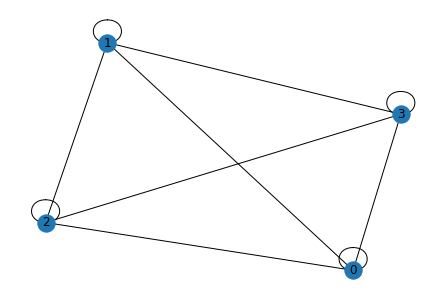

In [17]:
graph = nx.Graph()

for n in range(4):
    for b in range(4):
        graph.add_edges_from([[n, b]])
        graph.add_edge(n,b,weight =distance_data.iat[n, b])


        
nx.draw(graph, with_labels = True)

In [18]:
tsp_instance = Tsp(graph)
adj_matrix = nx.to_numpy_matrix(tsp_instance.graph)
print("distance\n", adj_matrix)

distance
 [[0.  2.7 3.7 7.2]
 [2.7 0.  4.5 3.7]
 [3.7 4.5 0.  3.5]
 [7.2 3.7 3.5 0. ]]


In [19]:
pos = nx.circular_layout(graph)
pos

{0: array([9.99999986e-01, 2.18556937e-08]),
 1: array([-3.57647606e-08,  1.00000000e+00]),
 2: array([-9.9999997e-01, -6.5567081e-08]),
 3: array([ 1.98715071e-08, -9.99999956e-01])}

In [20]:
# Converting the graph into the quadratic program
n = 4
num_qubits = n**2
qp = tsp_instance.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  2.7*x_0_0*x_1_1 + 2.7*x_0_0*x_1_3 + 3.7*x_0_0*x_2_1 + 3.7*x_0_0*x_2_3
  + 7.2*x_0_0*x_3_1 + 7.2*x_0_0*x_3_3 + 2.7*x_0_1*x_1_0 + 2.7*x_0_1*x_1_2
  + 3.7*x_0_1*x_2_0 + 3.7*x_0_1*x_2_2 + 7.2*x_0_1*x_3_0 + 7.2*x_0_1*x_3_2
  + 2.7*x_0_2*x_1_1 + 2.7*x_0_2*x_1_3 + 3.7*x_0_2*x_2_1 + 3.7*x_0_2*x_2_3
  + 7.2*x_0_2*x_3_1 + 7.2*x_0_2*x_3_3 + 2.7*x_0_3*x_1_0 + 2.7*x_0_3*x_1_2
  + 3.7*x_0_3*x_2_0 + 3.7*x_0_3*x_2_2 + 7.2*x_0_3*x_3_0 + 7.2*x_0_3*x_3_2
  + 4.5*x_1_0*x_2_1 + 4.5*x_1_0*x_2_3 + 3.7*x_1_0*x_3_1 + 3.7*x_1_0*x_3_3
  + 4.5*x_1_1*x_2_0 + 4.5*x_1_1*x_2_2 + 3.7*x_1_1*x_3_0 + 3.7*x_1_1*x_3_2
  + 4.5*x_1_2*x_2_1 + 4.5*x_1_2*x_2_3 + 3.7*x_1_2*x_3_1 + 3.7*x_1_2*x_3_3
  + 4.5*x_1_3*x_2_0 + 4.5*x_1_3*x_2_2 + 3.7*x_1_3*x_3_0 + 3.7*x_1_3*x_3_2
  + 3.5*x_2_0*x_3_1 + 3.5*x_2_0*x_3_3 + 3.5*x_2_1*x_3_0 + 3.5*x_2_1*x_3_2
  + 3.5*x_2_2*x_3_1 + 3.5*x_2_2*x_3_3 + 3.5*x_2_3*x_3_0 + 3.5*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    

In [21]:
from qiskit_optimization.converters import QuadraticProgramToQubo
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 3304.9999999999955
Ising Hamiltonian:
-413.5999999999999 * IIIIIIIIIIIIIIIZ
- 413.59999999999985 * IIIIIIIIIIIIIIZI
- 413.59999999999985 * IIIIIIIIIIIIIZII
- 413.5999999999998 * IIIIIIIIIIIIZIII
- 412.2499999999999 * IIIIIIIIIIIZIIII
- 412.24999999999994 * IIIIIIIIIIZIIIII
- 412.24999999999994 * IIIIIIIIIZIIIIII
- 412.2499999999999 * IIIIIIIIZIIIIIII
- 412.64999999999986 * IIIIIIIZIIIIIIII
- 412.64999999999986 * IIIIIIZIIIIIIIII
- 412.64999999999986 * IIIIIZIIIIIIIIII
- 412.64999999999986 * IIIIZIIIIIIIIIII
- 413.9999999999999 * IIIZIIIIIIIIIIII
- 413.9999999999999 * IIZIIIIIIIIIIIII
- 413.9999999999999 * IZIIIIIIIIIIIIII
- 413.9999999999999 * ZIIIIIIIIIIIIIII
+ 101.69999999999996 * IIIIIIIIIIIIIIZZ
+ 101.69999999999996 * IIIIIIIIIIIIIZIZ
+ 101.69999999999996 * IIIIIIIIIIIIIZZI
+ 101.69999999999996 * IIIIIIIIIIIIZIIZ
+ 101.69999999999996 * IIIIIIIIIIIIZIZI
+ 101.69999999999996 * IIIIIIIIIIIIZZII
+ 101.69999999999996 * IIIIIIIIIIIZIIIZ
+ 0.675 * IIIIIIIIIIIZIIZI
+ 0.675 * IIIIII

In [22]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 13.599999999999682
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=0.0, x_3_1=0.0, x_3_2=1.0, x_3_3=0.0
status: SUCCESS


In [23]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)


qaoa = QAOA(optimizer=spsa, quantum_instance=quantum_instance,reps = 5)

result = qaoa.compute_minimum_eigenvalue(qubitOp)


print("time:", result.optimizer_time)
x = tsp_instance.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp_instance.interpret(x)
print("solution:", z)
print("solution objective:", tsp_instance.tsp_value(z, adj_matrix))

time: 1256.904938697815
feasible: True
solution: [[1, 2, 3], [2, 3], [1, 2, 3], [0, 2, 3]]


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3,) (2,) 